In [321]:
import torch 
from torch import nn 
import sklearn 
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip3 install torchmetrics
from torchmetrics import Accuracy

# Circle Data

In [234]:
n_samples = 1000

x, y = make_circles(n_samples, noise=0.03, random_state=42)

In [235]:
len(x), len(y)

(1000, 1000)

In [236]:
x[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

# Create DataFrame

In [237]:
circles = pd.DataFrame({
    "x1": x[:, 0],
    "x2": x[:, 1],
    "label": y
})

circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


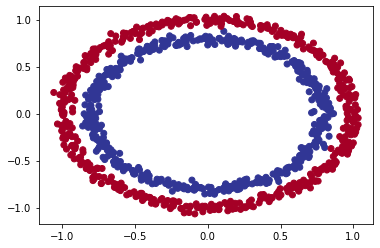

In [238]:
plt.scatter(x=circles["x1"], y=circles["x2"], c=circles["label"], cmap=plt.cm.RdYlBu)

# Train Test Split

In [239]:
X_train, X_test, y_train, y_test = train_test_split(
    circles[["x1", "x2"]], 
    circles["label"], 
    test_size=0.33, 
    random_state=42
)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), \
                                   y_train.to_numpy(), y_test.to_numpy()

print(
    X_train.shape,
    y_train.shape,
    X_test.shape,
    y_test.shape
)

(670, 2) (670,) (330, 2) (330,)


In [240]:
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

print(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape,
    sep='\n'
)

torch.Size([670, 2])
torch.Size([330, 2])
torch.Size([670])
torch.Size([330])


# Build Model

In [241]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [242]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)
        self.layer_4 = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.round(
            self.layer_4(
                self.layer_3(
                    self.layer_2(
                        self.layer_1(x)
                    )
                )
            )
        )

In [243]:
# model1 using model class

torch.manual_seed(42)

# model1 = CircleModel().to(device)
# model1

In [244]:
# model2 using nn.Sequential

torch.manual_seed(42)

model2 = nn.Sequential(
    nn.Linear(in_features=2, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=4),
    nn.ReLU(),
    nn.Linear(in_features=4, out_features=1)
).to(device)

model2

Sequential(
  (0): Linear(in_features=2, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): ReLU()
  (10): Linear(in_features=64, out_features=32, bias=True)
  (11): ReLU()
  (12): Linear(in_features=32, out_features=16, bias=True)
  (13): ReLU()
  (14): Linear(in_features=16, out_features=4, bias=True)
  (15): ReLU()
  (16): Linear(in_features=4, out_features=1, bias=True)
)

# Train

In [245]:
# model1 = CircleModel().to(device)

loss_fn = nn.BCEWithLogitsLoss()  # binary cross entropy with logits -> sigmoid
optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.01)

In [246]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    
    return acc

In [247]:
# train loop

torch.manual_seed(42)

epochs = 51
epoch_list = []
train_loss_list = []
test_loss_list = []
acc_list = []

for epoch in range(epochs):
    model2.train()
    preds_logits = model2(X_train).squeeze()
    loss_train = loss_fn(preds_logits, y_train)
    
    # Calculate Accuracy
    preds = torch.round(torch.sigmoid(preds_logits))
    acc = accuracy_fn(y_train, preds)
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    epoch_list.append(epoch)
    train_loss_list.append(loss_train)
    acc_list.append(acc)
    
    model2.eval()
    
    with torch.inference_mode():
        preds_logits = model2(X_test).squeeze()
        loss_test = loss_fn(preds_logits, y_test)
        test_loss_list.append(loss_test)
        
        preds = torch.round(torch.sigmoid(preds_logits))
        acc_test = accuracy_fn(y_test, preds)
        
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} \n \
            Train Accuracy: {acc:.3f}, Test Accuracy: {acc_test:.3f}\n \
            Training Loss: {loss_train:.3f}, \
            Testing Loss: {loss_test:.3f}\n"
        )

Epoch: 0 
             Train Accuracy: 48.657, Test Accuracy: 52.727
             Training Loss: 0.706,             Testing Loss: 0.693

Epoch: 10 
             Train Accuracy: 51.343, Test Accuracy: 47.273
             Training Loss: 0.693,             Testing Loss: 0.695

Epoch: 20 
             Train Accuracy: 97.612, Test Accuracy: 77.273
             Training Loss: 0.618,             Testing Loss: 0.531

Epoch: 30 
             Train Accuracy: 99.701, Test Accuracy: 73.333
             Training Loss: 0.075,             Testing Loss: 0.564

Epoch: 40 
             Train Accuracy: 97.612, Test Accuracy: 92.424
             Training Loss: 0.075,             Testing Loss: 0.148

Epoch: 50 
             Train Accuracy: 99.552, Test Accuracy: 100.000
             Training Loss: 0.013,             Testing Loss: 0.007



# Visualize Predictions

In [248]:
import requests
from pathlib import Path 

# Download helper functions from Learn Pytorch Repo

if Path("helper_functions.py").is_file():
    print("helper_function.py already exists, skipping download")
else:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from Utils.helper_functions import plot_predictions, plot_decision_boundary

helper_function.py already exists, skipping download


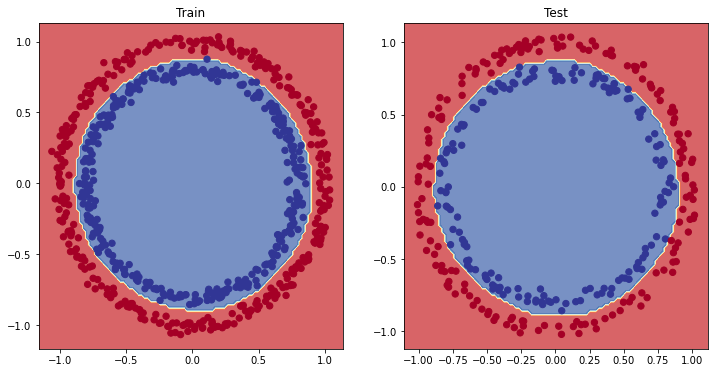

In [249]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)

# Multiclass Classification

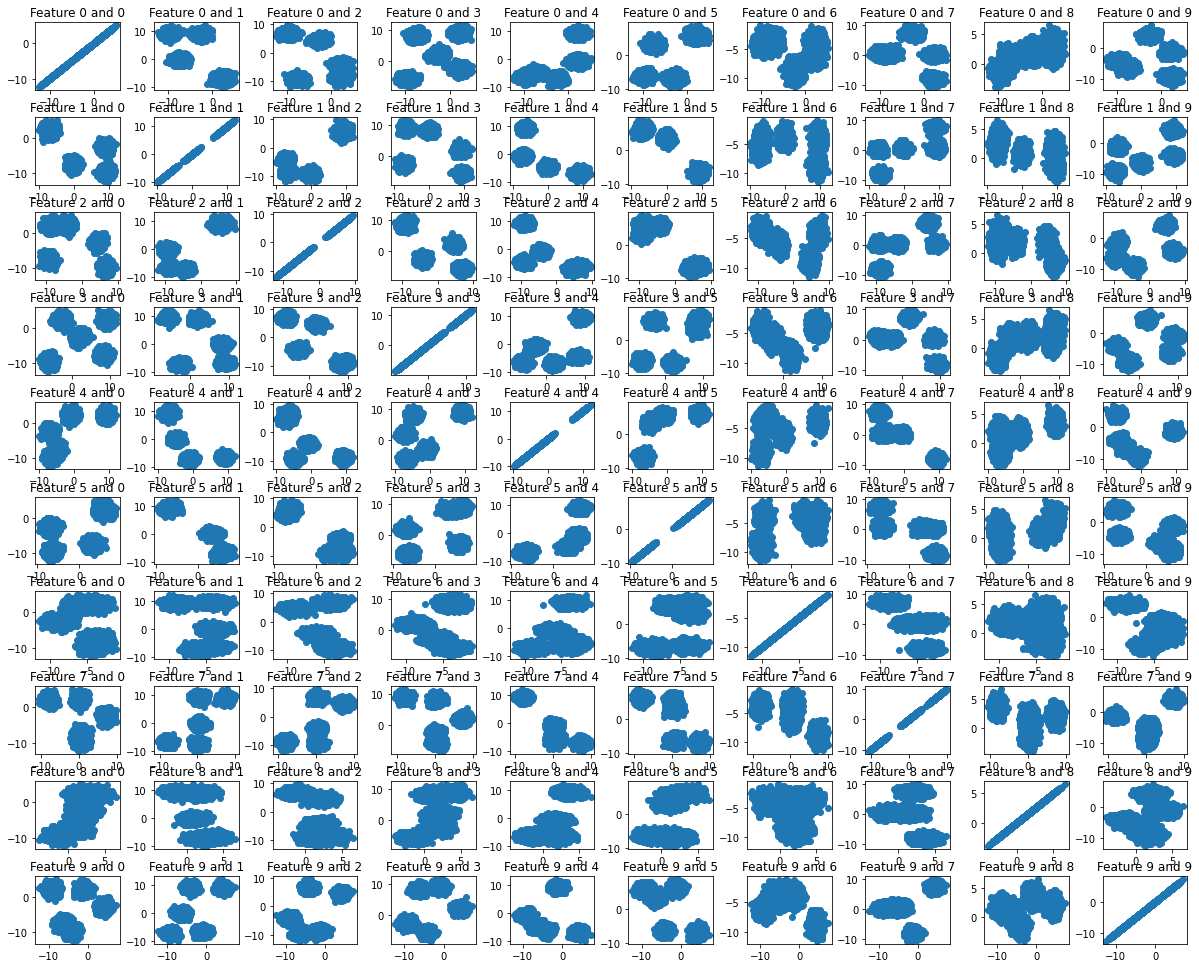

In [314]:
NUM_CLASSES = 5
NUM_FEATURES = 10
RANDOM_SEED = 42
TOTAL = 10000

X_blob, y_blob = make_blobs(
    n_samples=TOTAL, 
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=0.8,
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# train test split

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# visualization

plt.figure(figsize=(20,16))
cnt = 1

for i in range(NUM_FEATURES):
    for j in range(NUM_FEATURES):
        plt.subplot(NUM_FEATURES, NUM_FEATURES, cnt)
        cnt += 1
        plt.scatter(
            X_blob[:, i], 
            X_blob[:, j], 
            cmap=['Blue', 'Green', 'Red', 'Yellow', 'Black']
        )
        plt.subplots_adjust(
            left=0.1,
            bottom=0.1,
            right=0.9,
            top=0.9,
            wspace=0.4,
            hspace=0.4
        )
        plt.title(f"Feature {i} and {j}")
        
plt.show()

In [315]:
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device) 
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

# Build Model

In [316]:
class MultiClassModel(nn.Module):
    def __init__(self, input_features, num_class):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=num_class)
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layer_stack(x)

In [317]:
torch.manual_seed(42)

multiclass_model = MultiClassModel(NUM_FEATURES, NUM_CLASSES).to(device)
print(multiclass_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = multiclass_model.parameters(),
    lr = 0.001
)

MultiClassModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=8, bias=True)
    (15): ReLU()
    (16): Linear(in_features=8, out_features=5, bias=True)
  )
)


# Train

In [318]:
multiclass_model.eval()

with torch.inference_mode():
    y_preds = torch.argmax(
        nn.functional.softmax(
            multiclass_model(X_blob_test), 
            dim=1
        ), 
        dim = 1
    )
    
print(y_preds.shape, y_preds[:10], y_blob_test[:10], sep='\n')

torch.Size([2000])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 2, 0, 4, 4, 1, 2, 0, 2, 2])


In [319]:
torch.manual_seed(42)
epochs = 101

for epoch in range(epochs):
    multiclass_model.train()
    y_preds_logits = multiclass_model(X_blob_train)
    y_preds = torch.argmax(
        nn.functional.softmax(
            multiclass_model(X_blob_train),
            dim=1
        ), 
        dim=1
    )
    loss_train = loss_fn(y_preds_logits, y_blob_train)
    acc_train = accuracy_fn(y_blob_train, y_preds)
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    multiclass_model.eval()
    with torch.inference_mode():
        y_preds_logits = multiclass_model(X_blob_test)
        y_preds = torch.argmax(
            nn.functional.softmax(
                multiclass_model(X_blob_test),
                dim=1
            ),
            dim=1
        )
        
        loss_test = loss_fn(y_preds_logits, y_blob_test)
        acc_test = accuracy_fn(y_blob_test, y_preds)
        
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} \n \
            Training Acc: {acc_train}\n \
            Testing Acc: {acc_test} \n \
            Training Loss: {loss_train:.3f}, \n \
            Testing Loss: {loss_test:.3f}\n"
        )

Epoch: 0 
             Training Acc: 20.0
             Testing Acc: 20.0 
             Training Loss: 1.644, 
             Testing Loss: 1.635

Epoch: 10 
             Training Acc: 39.900000000000006
             Testing Acc: 40.400000000000006 
             Training Loss: 1.503, 
             Testing Loss: 1.473

Epoch: 20 
             Training Acc: 62.81250000000001
             Testing Acc: 76.44999999999999 
             Training Loss: 0.916, 
             Testing Loss: 0.884

Epoch: 30 
             Training Acc: 92.60000000000001
             Testing Acc: 80.2 
             Training Loss: 0.381, 
             Testing Loss: 0.377

Epoch: 40 
             Training Acc: 98.96249999999999
             Testing Acc: 99.8 
             Training Loss: 0.175, 
             Testing Loss: 0.168

Epoch: 50 
             Training Acc: 100.0
             Testing Acc: 100.0 
             Training Loss: 0.102, 
             Testing Loss: 0.098

Epoch: 60 
             Training Acc: 100.0
     

# Metrics

In [324]:
torchmetrics_accuracy = Accuracy(
    task="multiclass", 
    num_classes=NUM_CLASSES).to(device)
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(1.)